In [1]:
import numpy as np
import sacc
import matplotlib.pyplot as plt
import astropy.io.fits as pf

font = {'size'   : 14}
plt.rc('font', **font)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


In [2]:
data = sacc.Sacc.load_fits('twopoint_data.sacc')

/Users/chihwaychang/anaconda3/lib/python3.6/importlib/__init__.py:126: H5pyDeprecationWarning: The h5py.highlevel module is deprecated, code should import directly from h5py, e.g. 'from h5py import File'.
  return _bootstrap._gcd_import(name[level:], package, level)


In [3]:
print(data.get_theta_xi('galaxy_shear_xi_plus', 'source_'+str(i), 'source_'+str(j)))

NameError: name 'i' is not defined

In [4]:
# dir(data.tracers['source_0'])
ran = np.random.rand()*0.06 + 0.97
print(ran)

0.9940797196475099


In [5]:
paper = pf.open('2pt_NG_mcal_1110.fits')['covmat'].data
errp = np.diag(paper)[:200]**0.5
errm = np.diag(paper)[200:400]**0.5

/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


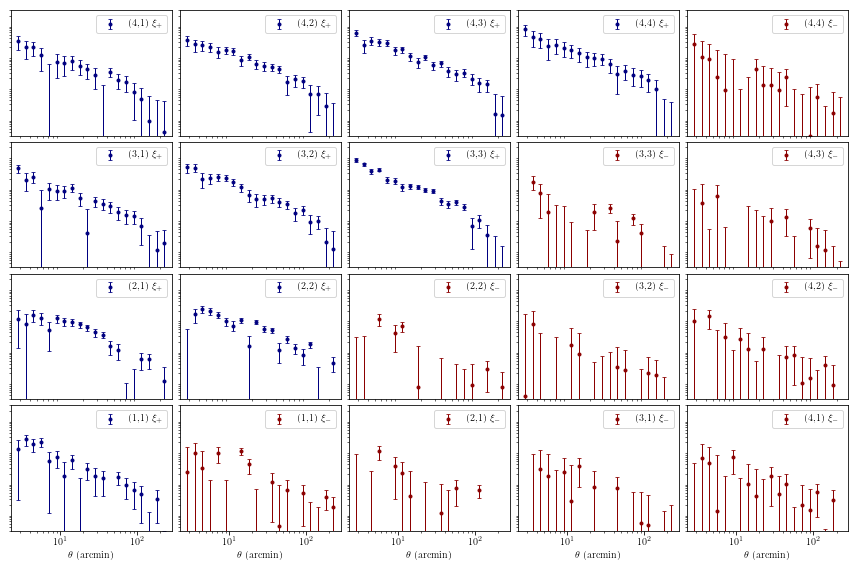

In [7]:
f = plt.figure(figsize=(15,12))
axes = f.subplots(4, 5, sharex='col', sharey='row', squeeze=True)

from matplotlib import gridspec

gs = gridspec.GridSpec(5, 5, width_ratios=[1, 1, 1,1,1],
         wspace=0.05, hspace=0.05)

nn = 0
for i in range(4):
    for j in range(4):
        if i>=j:
#             ax = plt.subplot(4,4,i*4+j+1)
            a= plt.subplot(gs[3-i,j])
#             a = axes[3-i,j]
            theta, xi = data.get_theta_xi('galaxy_shear_xi_plus', 'source_'+str(i), 'source_'+str(j))
            err = errp[nn*20:(nn+1)*20]
            
            a.errorbar(theta,xi*ran, err*ran, lw=1, color='navy', marker='.', fmt='.', capthick=0.8, capsize=2.2, label='('+str(i+1)+','+str(j+1)+') '+'$\\xi_{+}$')
            a.set_xscale('log')
            a.set_yscale('log')
            a.set_ylim(3e-8,3e-4)
            a.legend(loc='upper right')
            #if j!=0:
            a.get_yaxis().set_ticks([])
            if 3-i!=3:
                a.get_xaxis().set_ticks([])
            else:
                a.set_xlabel('$\\theta$ (arcmin)')

            b= plt.subplot(gs[3-j,i+1])
#             a = axes[3-i,j]
            theta, xi = data.get_theta_xi('galaxy_shear_xi_minus', 'source_'+str(i), 'source_'+str(j))
            err = errm[nn*20:(nn+1)*20]
            b.errorbar(theta,xi*ran, err*ran, lw=1, color='darkred', marker='.', fmt='.', capthick=0.8, capsize=2.2, label='('+str(i+1)+','+str(j+1)+') '+'$\\xi_{-}$')
            b.set_xscale('log')
            b.set_yscale('log')
            b.set_ylim(3e-8,3e-4)
            b.legend(loc='upper right')
            #if i+1!=0:
            b.get_yaxis().set_ticks([])
            if 3-j!=3:
                b.get_xaxis().set_ticks([])
            else:
                b.set_xlabel('$\\theta$ (arcmin)')

            nn+=1
            
plt.tight_layout()

plt.savefig('txpipe_desy1_tomo.png',bbox_inches='tight')

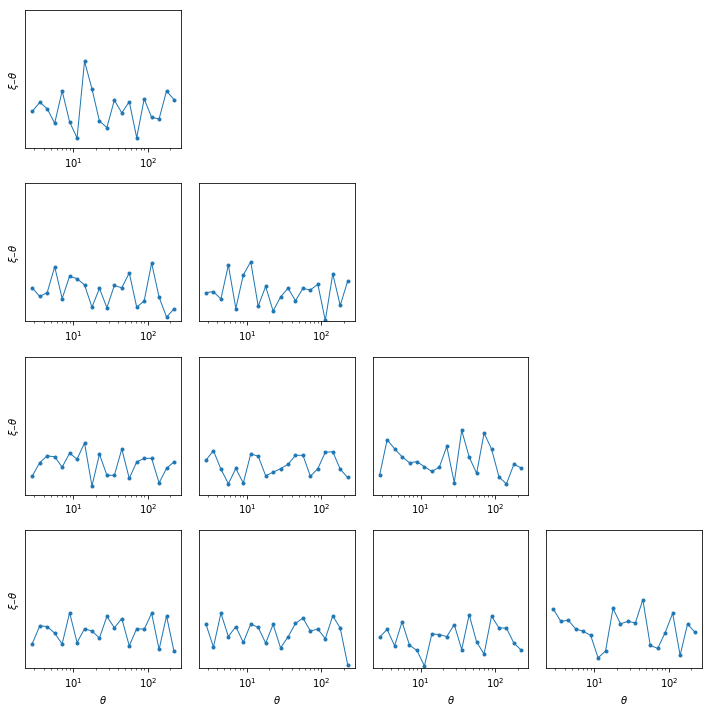

In [44]:
plt.figure(figsize=(10,10))

for i in range(4):
    for j in range(4):
        if i>=j:
            ax = plt.subplot(4,4,i*4+j+1)
            theta, xi = data.get_theta_xi('galaxy_shear_xi_minus', 'source_'+str(i), 'source_'+str(j))
            
            plt.semilogx(theta,theta*xi, marker='.', lw=1)
            plt.ylim(-1e-4,3e-4)
            ax.get_yaxis().set_ticks([])
        if j==0:
            plt.ylabel('$\\xi_{-} \\theta$')
        if i==3:
            plt.xlabel('$\\theta$')

plt.tight_layout()

In [ ]:
W = "w"
GAMMA = "gammat"
XIP = "xip"
XIM = "xim"


def make_axis(i, j, nx, ny, axes):
    if i==0 and j==0:
        shares = {}
    elif j==0:
        shares = {'sharex': axes[0,0]}
    elif i==j:
        shares = {'sharey': axes[i,0]}
    else:
        shares = {'sharey': axes[i,0], 'sharey': axes[j,j]}

    a = plt.subplot(ny, nx, i*ny+j+1, **shares)
    axes[i,j] = a
    return a


def full_3x2pt_plots(sacc_files, labels, cosmo=None, theory_sacc_files=None, theory_labels=None):
    sacc_data = [sacc.Sacc.load_fits(sacc_file) for sacc_file in sacc_files]
    obs_data = [extract_observables_plot_data(s, label) for s, label in zip(sacc_data, labels)]
    plot_theory = (cosmo is not None)


    if plot_theory:
        theory_sacc_data = [sacc.Sacc.load_fits(sacc_file) for sacc_file in theory_sacc_files]
        # By default, just plot a single theory line, not one per observable line
        # Label it "Theory"
        if theory_sacc_files is None:
            theory_sacc_data = sacc_data[:1]
            theory_labels = ["Theory"]
        else:
            # But if specified, can provide multiple theory inputs, and then 
            if theory_labels is None:
                raise ValueError("Must provide theory names if you provide theory sacc files")
        # Get the ranges from the first obs data set
        theory_data = [make_theory_plot_data(s, cosmo, obs_data[0], label) 
                       for (s, label) in zip(theory_sacc_data, theory_labels)]
    else:
        theory_data = []


    return [make_plot(c, obs_data, theory_data)
        for c in [XIP, XIM, GAMMA, W]]
    

def axis_setup(a, i, j, ny, ymin, ymax, name):
    if j>0:
        plt.setp(a.get_yticklabels(), visible=False)
    else:
        a.set_ylabel(f"${name}$")
    if i<ny:
        plt.setp(a.get_xticklabels(), visible=False)
    else:
        plt.xlabel(r"$\theta / $ arcmin")

    a.tick_params(axis='both', which='major', length=10, direction='in')
    a.tick_params(axis='both', which='minor', length=5, direction='in')

    # Fix
    a.text(0.1, 0.1, f"Bin {i}-{j}", transform=a.transAxes)
    if i==j==0:
        a.legend()
    a.set_ylim(ymin, ymax)

def make_plot(corr, obs_data, theory_data):
    nbin_source = obs_data[0]['nbin_source']
    nbin_lens = obs_data[0]['nbin_lens']

    if corr == XIP:
        ny = nbin_source
        nx = nbin_source
        name = r"\xi_+(\theta)"
        ymin = 5e-7
        ymax = 9e-5
        auto_only = False
        half_only = True
    elif corr == XIM:
        ny = nbin_source
        nx = nbin_source
        name = r"\xi_-(\theta)"
        ymin = 5e-7
        ymax = 9e-5
        auto_only = False
        half_only = True
    elif corr == GAMMA:
        ny = nbin_source
        nx = nbin_lens
        ymin = 5e-7
        ymax = 2e-3
        name = r'\gamma_T(\theta)'
        auto_only = False
        half_only = False
    elif corr == W:
        ny = nbin_lens
        nx = nbin_lens
        ymin = 2e-4
        ymax = 1e-1
        name = r'w(\theta)'
        auto_only = True
        half_only = False

    plt.rcParams['font.size'] = 14
    f = plt.figure(figsize=(nx*3, ny*3))
    ax = {}
    
    axes = f.subplots(ny, nx, sharex='col', sharey='row', squeeze=False)
    for i in range(ny):
        if auto_only:
            J = [i]
        elif half_only:
            J = range(i+1)
        else:
            J = range(nx)
        for j in range(nx):
            a = axes[i,j]
            if j not in J:
                f.delaxes(a)
                continue

            for obs in obs_data:
                theta, xi = obs[(corr, i, j)]
                a.loglog(theta, xi, '+', label=obs['name'])

            for theory in theory_data:
                theta, xi = theory[(corr, i, j)]
                a.loglog(theta, xi, '-', label=theory['name'])

            axis_setup(a, i, j, ny, ymin, ymax, name)

    f.suptitle(rf"TXPipe ${name}$")

    # plt.tight_layout()
    f.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.subplots_adjust(wspace=0.0, hspace=0.0)
    return plt.gcf()

def smooth_nz(nz):
    return np.convolve(nz, np.exp(-0.5*np.arange(-4,5)**2)/2**2, mode='same')


def extract_observables_plot_data(data, label):
    obs = {'name': label}

    nbin_source = len([t for t in data.tracers if t.startswith('source')])
    nbin_lens   = len([t for t in data.tracers if t.startswith('lens')])

    obs['nbin_source'] = nbin_source
    obs['nbin_lens'] = nbin_lens

    for i in range(nbin_source):
        for j in range(i+1):
            obs[(XIP, i, j)] = data.get_theta_xi('galaxy_shear_xi_plus', f'source_{i}', f'source_{j}')
            obs[(XIM, i, j)] = data.get_theta_xi('galaxy_shear_xi_minus', f'source_{i}', f'source_{j}')

    for i in range(nbin_lens):
        obs[W, i, i] = data.get_theta_xi('galaxy_density_xi', f'lens_{i}', f'lens_{i}')


    for i in range(nbin_source):
        for j in range(nbin_lens):
            obs[(GAMMA, i, j)] = data.get_theta_xi('galaxy_shearDensity_xi_t', f'source_{i}', f'lens_{j}')

    return obs

def make_theory_plot_data(data, cosmo, obs, label, smooth=True):
    import pyccl

    theory = {'name': label}

    nbin_source = obs['nbin_source']
    nbin_lens   = obs['nbin_lens']

    ell = np.unique(np.logspace(np.log10(2),5,400).astype(int))

    tracers = {}
    for i in range(nbin_source):
        name = f'source_{i}'
        Ti = data.get_tracer(name)
        if smooth:
            nz = smooth_nz(Ti.nz)
        else:
            nz = Ti.nz
        tracers[name] = pyccl.WeakLensingTracer(cosmo, (Ti.z, nz))

    for i in range(nbin_lens):
        name = f'lens_{i}'
        Ti = data.get_tracer(name)
        if smooth:
            nz = smooth_nz(Ti.nz)
        else:
            nz = Ti.nz
        tracers[name] = pyccl.NumberCountsTracer(cosmo, has_rsd=False, 
            dndz=(Ti.z, nz), bias=(Ti.z, np.ones_like(Ti.z)))


    for i in range(nbin_source):
        for j in range(i+1):
            theta, _ = obs[(XIP, i, j)]
            cl = pyccl.angular_cl(cosmo, tracers[f'source_{i}'], tracers[f'source_{j}'], ell)
            print(f"Computing theory xip/m ({i},{j})")
            theory[(XIP, i, j)] = theta, pyccl.correlation(cosmo, ell, cl, theta/60, 'L+')
            theory[(XIM, i, j)] = theta, pyccl.correlation(cosmo, ell, cl, theta/60, 'L-')

    for i in range(nbin_lens):
        theta, _ = obs[(W, i, i)]
        print(f"Computing theory w ({i},{i})")
        cl = pyccl.angular_cl(cosmo, tracers[f'source_{i}'], tracers[f'source_{j}'], ell)
        theory[W, i, i] = theta, pyccl.correlation(cosmo, ell, cl, theta/60, 'GG')


    for i in range(nbin_source):
        for j in range(nbin_lens):
            theta, _ = obs[(GAMMA, i, j)]
            print(f"Computing theory gamma_t ({i},{j})")
            cl = pyccl.angular_cl(cosmo, tracers[f'source_{i}'], tracers[f'lens_{j}'], ell)
            theory[GAMMA, i, j] = theta, pyccl.correlation(cosmo, ell, cl, theta/60, 'GL')

    return theory